In [2]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [60]:
df = pd.read_csv('HealthExpend.csv', usecols=['AGE', 'famsize', 'COUNTIP', 'COUNTOP', 'EXPENDIP', 'EXPENDOP'])
X = df.iloc[:, 0:-1]
y = df[['EXPENDOP']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

сначала смотрим на данные:

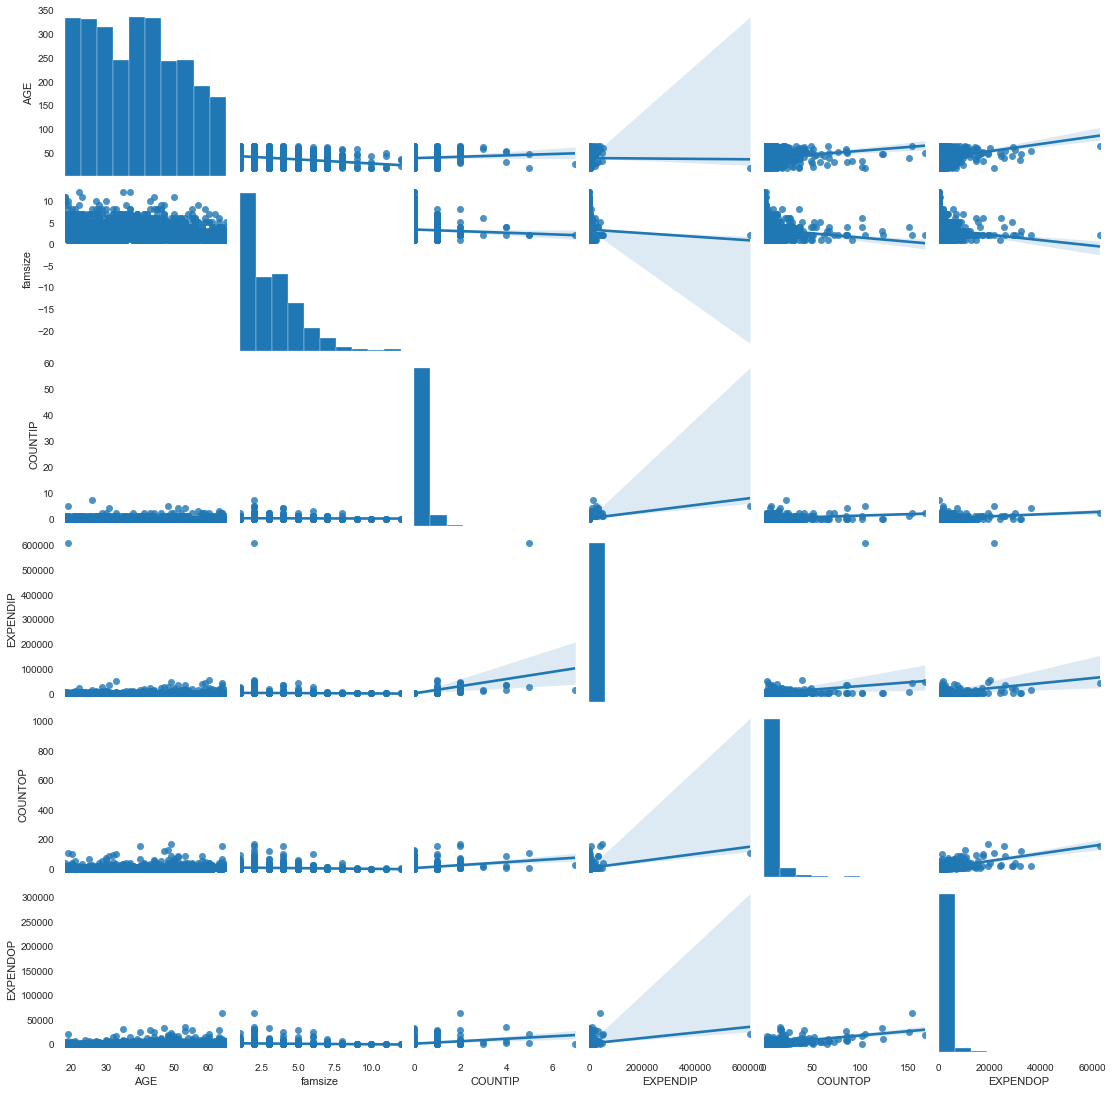

In [31]:
sns.pairplot(df)
plt.savefig('pairplot_reg.png')

видим, что данные не очень, и что величина, которую мы пытаемся предсказать имеет плохое распределение(большинство нулей)
смотрим на кореляцию:

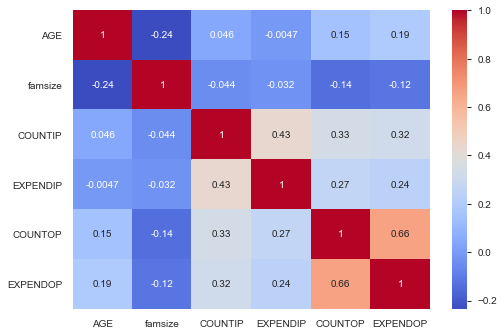

In [32]:
cor = df.corr()
sns.heatmap(cor, cmap='coolwarm', annot=True)
plt.savefig('heastmap.png')

видим что регрессоры не очень корелируют с таргетом, разве что COUNTOP (0.66)
также, кореляция EXPENDIP и COUNTIP =  0.43, что вполне логично, но не очень полезно для модели
Попробуем регрессию:

In [33]:
linear = LinearRegression()
linear.fit(X_train, y_train)
print(f'Оцінка МНК для коефіцієнтів регресії: {linear.coef_}')
print(f'Оцінка МНК для вільного члена: {linear.intercept_}')
y_pred = linear.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R^2: {r2}')
print(f'MSE: {mse}')
residuals = y_test - y_pred
var = np.var(residuals**2).values
print(f'Дисперсія: {var}')

Оцінка МНК для коефіцієнтів регресії: [[ 2.44805870e+01 -2.09890484e+00  8.62585111e+02  1.66640607e+02
   6.80220947e-03]]
Оцінка МНК для вільного члена: [-715.96320666]
R^2: 0.37524677870966394
MSE: 3769074.456517428
Дисперсія: [5.80484928e+14]


как видим, результат неочень - коеф. детерминации не сильно большой, а дисперсии как раз дофига
посмотрим на график остатков:

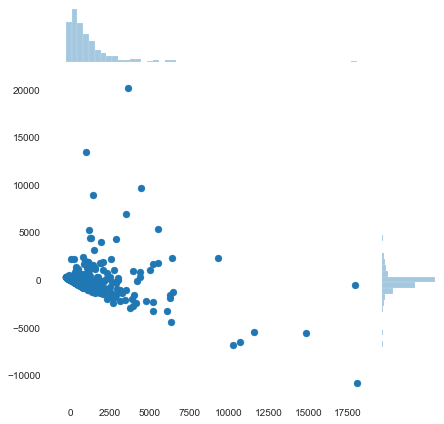

In [34]:
sns.jointplot(y_pred, residuals)
plt.savefig('residuals.png')

тут видим, что остатки не симетричны относительно y = 0 и также наблюдаеться некоторая гетероскедастичность
посмотрим что получиться с гребневой регрессией:

In [11]:
ridgecv = RidgeCV(alphas=[10e-1, 10e0, 10e1, 10e2, 10e3, 10e4], store_cv_values=True)
results = ridgecv.fit(X_train, y_train)
y_pred = ridgecv.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R^2: {r2}')
residuals = y_test - y_pred
var = np.var(residuals**2).values
print(f'Дисперсія: {var}')
print(f'Підібране значення гіперпараметру: {results.alpha_}')

R^2: 0.3871292761933418
Дисперсія: [5.56942907e+14]
Підібране значення гіперпараметру: 1000.0


разницы почти никакой((
дальше попробуем метод главных компонент:

Пояснена дисперсія: [9.99998398e-01 9.34531335e-07 6.51538459e-07 1.52118800e-08
 6.74310646e-10]


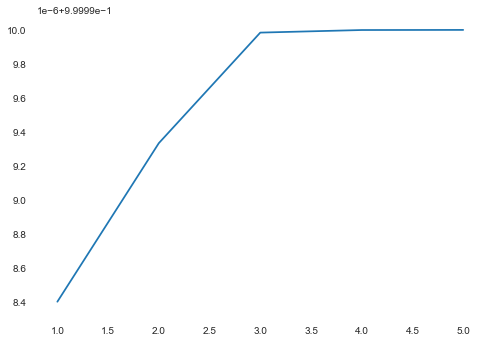

In [61]:
pca = PCA()
pca.fit(X)
sns.lineplot([1, 2, 3, 4, 5], np.cumsum(pca.explained_variance_ratio_))
print('Пояснена дисперсія:', pca.explained_variance_ratio_)

на построеном графике кумулятивной обьясненной дисперсии видно, что 3-х главных компонент хватает

In [62]:
pca = PCA(n_components=3)
X_3D = pca.fit_transform(X)
X_train, X_test = train_test_split(X_3D, test_size=0.2, random_state=42)
ridge = Ridge(alpha=10e2)
ridge.fit(X_train, y_train)
print('R^2:', ridge.score(X_test, y_test))

R^2: 0.38747864594578385


видим, что коеф. детерминации даже выше, чем со всеми пятью регрессорами

одним из более простых способов отобрать лучшие фичи - выбрать те, что корелируют с таргетом
так и поступим:

In [35]:
cor_target = abs(cor['EXPENDOP'])
best_features = cor_target[cor_target>0.5]
best_features

COUNTOP     0.664992
EXPENDOP    1.000000
Name: EXPENDOP, dtype: float64

получили единственный регрессор COUNTOP, что и было видно из графика вначале
так же нужно выбирать фичи, некорелирующие между собой, то есть например из COUNTIP и EXPENDIP следовало бы одну отбросить
следовательно, попробуем использовать наш единственный регрессор:

In [52]:
countop = X['COUNTOP']
train, test = train_test_split(countop, test_size=0.2, random_state=42)
ridge = Ridge(alpha=10e2)
ridge.fit(train.values.reshape(-1, 1), y_train)
print('R^2:', ridge.score(test.values.reshape(-1, 1), y_test))

R^2: 0.3651559386089489


получили почти такой же результат, хотя использовали всего один регрессор

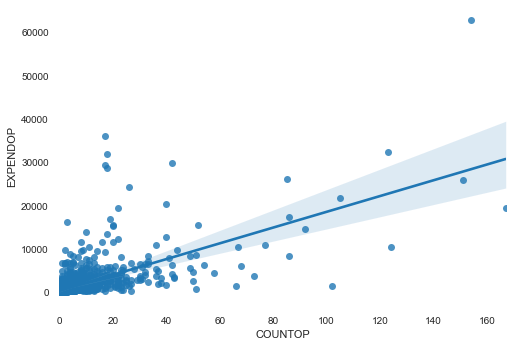

In [45]:
sns.regplot(train, y_train)

в целом, модель получаеться неудовлетворительная, поскольку структура данных оставляет желать лучшего